In [327]:
import pandas as pd
from scipy.stats import binom_test, fisher_exact
from genepy.utils import helper as h 
from genepy.imaging import fish
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind
from scipy.spatial import distance_matrix
import numpy as np

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Processing the data

In [3]:
project='FishSuperResColoc'
version='v2'

In [4]:
rename = {
"Text Between Delimiters":"subset",
"Folder Short":"folder_short",
"Folder Path":"folder",
"Source.Name":"name",
"ImageDocumentName::Image Name":"image",
"ParentID::ID of the parent!!I":"parent_id",
"ID::ID!!I":"id",
"RegionsCount::Count!!I": "count",
"ImageSceneName::Image Scene Name ":"scene",
"Area1::Area Unscaled!!R":"area_u",
"Area::Area!!R": "area",
"CenterX1::Center X Unscaled!!R":"x",
"CenterY1::Center Y Unscaled!!R":"y",
"ImageScaleX::Image Scale X!!R":"scale_x",
"ImageScaleY::Image Scale Y!!R":"scale_y",
"ImageIndexZ::Image Index Z!!I":"z",
'Classes 5 RegionsCount ::Classes 5 Count!!I':"count_red",
'Classes 9 RegionsCount ::Classes 9 Count!!I':"count_green",
"ClassColorName::Region Class Color Name": "class",
"IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R":"max_red",
"IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R":"max_tv2_t1",
"IntensityMaximum_TV2-T2-SR::Intensity Maximum of channel 'TV2-T2-SR'!!R":"max_green",
"IntensityMaximum_TV2-T3-SR::Intensity Maximum of channel 'TV2-T3-SR'!!R":"max_dapi",
"IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R":"mean_red",
"IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R":"mean_tv2_t1",
"IntensityMean_TV2-T2-SR::Intensity Mean Value of channel 'TV2-T2-SR'!!R":"mean_green",
"IntensityMean_TV2-T3-SR::Intensity Mean Value of channel 'TV2-T3-SR'!!R":"mean_dapi",
"IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R":"min_red",
"IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R":"min_tv2_t1",
"IntensityMinimum_TV2-T2-SR::Intensity Minimum of channel 'TV2-T2-SR'!!R":"min_green",
"IntensityMinimum_TV2-T3-SR::Intensity Minimum of channel 'TV2-T3-SR'!!R":"min_dapi",
"IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R":"pixsum_red",
"IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R":"pixsum_tv2_t1",
"IntensitySum0_TV2-T2-SR::Intensity Pixel Count of channel 'TV2-T2-SR'!!R":"pixsum_green",
"IntensitySum0_TV2-T3-SR::Intensity Pixel Count of channel 'TV2-T3-SR'!!R":"pixsum_dapi",
"IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R":"range_red",
"IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R":"range_tv2_t1",
"IntensityRange_TV2-T2-SR::Intensity Range of channel 'TV2-T2-SR'!!R":"range_green",
"IntensityRange_TV2-T3-SR::Intensity Range of channel 'TV2-T3-SR'!!R":"range_dapi",
"IntensityStd_TV1-T1-SR::Intensity Standard Deviation of channel 'TV1-T1-SR'!!R":"std_red",
"IntensityStd_TV2-T1-SR::Intensity Standard Deviation of channel 'TV2-T1-SR'!!R":"std_tv2_t1",
"IntensityStd_TV2-T2-SR::Intensity Standard Deviation of channel 'TV2-T2-SR'!!R":"std_green",
"IntensityStd_TV2-T3-SR::Intensity Standard Deviation of channel 'TV2-T3-SR'!!R":"std_dapi",
"IntensitySum1_TV1-T1-SR::Intensity Sum of channel 'TV1-T1-SR'!!R":"sum_red",
"IntensitySum1_TV2-T1-SR::Intensity Sum of channel 'TV2-T1-SR'!!R":"sum_tv2_t1",
"IntensitySum1_TV2-T2-SR::Intensity Sum of channel 'TV2-T2-SR'!!R":"sum_green",
"IntensitySum1_TV2-T3-SR::Intensity Sum of channel 'TV2-T3-SR'!!R":"sum_dapi",
"IntensitySum2_TV1-T1-SR::Intensity Sum Squares of channel 'TV1-T1-SR'!!R":"sum2_red",
"IntensitySum2_TV2-T1-SR::Intensity Sum Squares of channel 'TV2-T1-SR'!!R":"sum2_tv2_t1",
"IntensitySum2_TV2-T2-SR::Intensity Sum Squares of channel 'TV2-T2-SR'!!R":"sum2_green",
"IntensitySum2_TV2-T3-SR::Intensity Sum Squares of channel 'TV2-T3-SR'!!R":"sum2_dapi",
"Unnamed: 27":"unknown"
}

In [80]:
data = pd.read_csv('../data/'+project+'/data_query_files/querry.csv').rename(columns=rename)
data

,subset,folder_short,folder,name,image,parent_id,id,scene,area,x,...,sum_1,sum_2,range_1,range_2,std_1,std_2,sum1_1,sum1_2,sum2_1,sum2_2
0,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,NaN,NaN,NaN,NaN,pixel²,pixel,...,pixel²,pixel²,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown²,Unknown²
1,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,15.0,NaN,7,368.64285714286,...,7,7,1661,4080,547.72403548468,1510.241245314,49094,164490,346117272,3878964986
2,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,16.0,NaN,28,396.21428571429,...,28,28,8089,13818,2760.2006509669,3701.1435641623,123989,523204,754750539,10146373720
3,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,17.0,NaN,13,426.88461538462,...,13,13,4583,6576,1313.3590522016,2101.7813019022,108303,285907,922971237,6340918481
4,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,18.0,NaN,29,340.74137931035,...,29,29,3515,12083,1077.0374837392,3107.8328355138,196046,460225,1357791794,7574132899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117757,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,23.0,NaN,55230,1146.4196089082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117758,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,24.0,NaN,60384,1546.5754835718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117759,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,25.0,NaN,48042,2480.9880521211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117760,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,26.0,NaN,70306,1932.6927004808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.columns

Index(['subset', 'folder_short', 'folder', 'name', 'image', 'parent_id', 'id',
       'scene', 'area', 'x', 'y', 'max_1', 'max_2', 'mean_1', 'mean_2',
       'min_1', 'min_2', 'sum_1', 'sum_2', 'range_1', 'range_2', 'std_1',
       'std_2', 'sum1_1', 'sum1_2', 'sum2_1', 'sum2_2'],
      dtype='object')

In [5]:
cat ../data/$project/data_query_files/querry.csv | less

<U+FEFF>Text Between Delimiters,Folder Short,Folder Path,Source.Name,ImageDocumentName::Image Name,ParentID::ID of the parent!!I,ID::ID!!I,ImageSceneName::Image Scene Name ,Area1::Area Unscaled!!R,CenterX1::Center X Unscaled!!R,CenterY1::Center Y Unscaled!!R,IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R,IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R,IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R,IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R,IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R,IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R,IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R,IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R,IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R,IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R,IntensityStd_TV1-T1-SR::Int

In [ ]:
data.iloc[0].tolist()

In [ ]:
set(data.folder_short)

In [ ]:
cond = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'AAVS1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'AAVS1',
 'IF FISH final\\IRF2BP2_excel\\':'',
 'IF FISH final\\MEF2C_excel\\':'',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MEF2D',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':''}

In [ ]:
prot = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'MED1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\IRF2BP2_excel\\':'IRF2BP2',
 'IF FISH final\\MEF2C_excel\\':'MEF2C',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MED1',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':'RUNX2'}

In [ ]:
data = data[~data.name.str.contains('Classes')]

In [ ]:
data['condition'] = [cond[i] for i in data.folder_short]

In [ ]:
data['protein'] = [prot[i] for i in data.folder_short]

In [ ]:
data['type'] = [i.split('.')[0].split('_')[-1] for i in data.name]

In [ ]:
data['name'] = [cond[i]+'_'+prot[i] for i in data.folder_short]

In [ ]:
set(data.type)

In [ ]:
data = data[~data.id.isna()]

In [ ]:
set(data.subset)

In [ ]:
data = data.drop(columns=['scene','image','folder','folder_short'])

In [ ]:
data['subset'] = [i.split('Subset')[-1] for i in data.subset]

In [ ]:
for val in ['area','x','y','max_1','max_2','mean_1','mean_2','min_1','min_2','range_1','range_2','std_1','std_2','sum_1','sum_2','sum1_1','sum1_2','sum2_1','sum2_2']:
    data[val]= data[val].astype(float)

In [ ]:
for val in ['subset','parent_id','id']:
    data[val] = data[val].astype('int')

In [ ]:
len(data.id)

# results

## why we are not doing a monte carlo but just a hypthesis testing on a binomial

monte carlo would be useful in our case if we did not know the expected distribution.
given a way to generate our distribution (which specific parameters can be learnt from the data) we might be able to express what would be the null hypothesis by estimating this unknown distribution. it is useful for when we don't know the exact distribution or when it is too complex to analytically solve.  

However in our case we can approximate the distribution well enough by a binomial. It is true that given that the dna will not have the same density everywhere on the nucleus, that the dots will have themselves variable intensity and size, which might express or not a multiplicity of points, the distribution is not a binomial. 

But you said yourself that for all purposes we could simplify these hypothesis. 

I also don't think that we have enough data points to correctly estimate the monte carlo parameters. 

A binomial is thus enough for this analysis

### having specificities in the data needing to be modelled:

I found that the data has specific bias that still need to be taken in account while not needing to change the statistics:

the avg size of a MYC dot is 350 whereas the one of a MYC green is 45

In [ ]:
def desc(data):
    return data.sum()/data.mean(),len(data)
# for each group
res = {}
for val in set(data.name):
    print('\n',val)
    group = data[data.name==val]
    space = group[group.type=='Nucleus'].area.sum()
    totsize = group[group.type==' Green Dots'].area.sum()
                 
    coloc,s_coloc = desc(group[group.type=='MYC  Green'].area)
    outside,s_outside = desc(group[group.type=='MYC'].area)
    print('data: \n  - total nucleuses size: '+str(int(space))+'\n  - total Green dot size: '+str(int(totsize))+'\n  - counts for coloc: '+str(int(s_coloc))+'\n  - counts for not coloc: '+str(int(s_outside))) 
    p_in = totsize/space
    isin = coloc/(outside+coloc)
    res[val] = [s_coloc,s_outside]
    print('proba: (null, obs)',p_in,isin)
    print('nb of datapoints: ',s_coloc+s_outside)
    print('p_value: ',binom_test([s_coloc,s_outside],p=p_in))

from this analysis it seems clear that the colocalization happens less than 50% of the time in any condition but that we have colocalization with MYC for all analyzed proteins compared to random chance, given the data extracted by the algorithm and the assumption we made.

In [ ]:
fisher_exact([res['AAVS1_MED1'], res['MEF2D_MED1']])

In [ ]:
fisher_exact([res['AAVS1_MEF2D'], res['MEF2D_MEF2D']])

we thus have much 1.7 times more colocalization of MEF2D when MEF2D is degraded vs when it is not and 2 times less colocalization of MED1 but p_val of .1

# running new version

## Loading

In [4]:
project='FishSuperResColoc'
version='v3'

In [531]:
csvs = ! ls ../data/$project/Yaser3/*/*.csv
res = pd.DataFrame()
for val in csvs:
    v = pd.read_csv(val,).drop(index=0)
    v['filename'] = '-'.join(val.split('/')[-2].split('-')[2:])
    res = res.append(v)
res = res.rename(columns=rename)
res.parent_id = res.parent_id.astype(int)
res.id = res.id.astype(int)
res.area = res.area.astype(float)
res = res.reset_index(drop=True)

In [532]:
zsize = 85 

## labelling

In [533]:
values =  ['area', 'x', 'y', "z", "scale_x", "scale_y", "count_red", "count_green", "max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi"]
res[values] = pd.concat([res[i].astype(str).str.replace('  ','0').replace(' ','0').replace('', '0').replace('None',"0").astype(float) for i in values], axis=1)
res['x']= res['x']*res["scale_x"]
res['y']= res['y']*res["scale_y"]
res["z"]= res['z']*zsize
res = res.drop(columns=['area_u',"scale_x",'scale_y'])
set(res['filename'])

{'MED1-MYC_MEF2D-DMSO-G1',
 'MED1-MYC_MEF2D-VHL-G1',
 'MEF2D-MYC_MEF2D-DMSO-G1',
 'MEF2D-MYC_MEF2D-VHL-G1'}

In [534]:
set(res['image'])

{'Image 11_Out_Channel Alignment_P1-1.czi',
 'Image 11_Out_Channel Alignment_P1-1_2.czi',
 'Image 11_Out_Channel Alignment_P1-2.czi',
 'Image 11_Out_Channel Alignment_P1-2_2.czi',
 'Image 11_Out_Channel Alignment_P2-1.czi',
 'Image 11_Out_Channel Alignment_P2-1_2.czi',
 'Image 11_Out_Channel Alignment_P2-1_3.czi',
 'Image 11_Out_Channel Alignment_P2-2.czi',
 'Image 11_Out_Channel Alignment_P2-2_2.czi',
 'Image 11_Out_Channel Alignment_P2-3_Subset.czi',
 'Image 11_Out_Channel Alignment_P3.czi',
 'Image 11_Out_Channel Alignment_P3_1.czi',
 'Image 11_Out_Channel Alignment_P4-1.czi',
 'Image 11_Out_Channel Alignment_P4-2-2.czi',
 'Image 11_Out_Channel Alignment_P4-2-2_2.czi',
 'Image 11_Out_Channel Alignment_P4-2.czi',
 'Image 11_Out_Channel Alignment_P4-2_1.czi',
 'Image 11_Out_Channel Alignment_P4-2_2.czi',
 'Image 11_Out_Channel Alignment_P4-2_3.czi',
 'Image 11_Out_Channel Alignment_P5.czi',
 'Image 11_Out_Channel Alignment_P5_2.czi',
 'Image 11_Out_Channel Alignment_P6-1.czi',
 'Image

In [535]:
imageinfo = res['image'].str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')
res['group'] = res['filename'] + "--" + imageinfo
# todo redo
res['exp'] = ['-'.join(i.split('-')[:2]) for i in res.filename]
res['treat'] = [i.split('-')[-2] for i in res.filename]
res['image'] = [i.split('--')[0] for i in imageinfo]
res['part'] = [i.split('--')[-1] for i in imageinfo]
set(res.exp)

<ipython-input-535-f6b99e8e6f64>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  imageinfo = res['image'].str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')


{'MED1-MYC_MEF2D', 'MEF2D-MYC_MEF2D'}

In [536]:
res['class'] = res['class'].replace({'Orange':"dapi", 'Fuchsia': "green", "Yellow": 'red'})
res = res.drop(index=res[res['class'].isna()].index)

vals=['parent_id',"id","area","x",'y',"z","count_red","count_green"]
res[vals] = res[vals].astype(int)
cells = res[res["parent_id"]==1]
dots = res[res["parent_id"]!=1]
cells[['count_red','count_green']].mean()

count_red       0.491960
count_green    14.221591
dtype: float64

In [537]:
len(cells),len(dots), res['id'].max()

(9328, 137248, 143)

## colocallizing

In [538]:
mdots = fish.colocalize(dots, distance_scale=1.2)

MEF2D-MYC_MEF2D-VHL-G1--5--5-1
MEF2D-MYC_MEF2D-VHL-G1--5--3-1


/home/jeremie/genepy/genepy/imaging/fish.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdot[mergedidcol]=None
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


MED1-MYC_MEF2D-VHL-G1--11--2-2
MEF2D-MYC_MEF2D-VHL-G1--5--1-1_2
MED1-MYC_MEF2D-DMSO-G1--13--4-3_2
MED1-MYC_MEF2D-VHL-G1--11--3
MEF2D-MYC_MEF2D-DMSO-G1--4--3-1
MED1-MYC_MEF2D-VHL-G1--11--6-3_2
MED1-MYC_MEF2D-DMSO-G1--13--3-3
MEF2D-MYC_MEF2D-DMSO-G1--4--3-2_1
MEF2D-MYC_MEF2D-VHL-G1--5--1-1
MED1-MYC_MEF2D-DMSO-G1--13--4-3
MEF2D-MYC_MEF2D-VHL-G1--5--2-3
MEF2D-MYC_MEF2D-VHL-G1--5--4-1
MED1-MYC_MEF2D-VHL-G1--11--4-2-2_2
MED1-MYC_MEF2D-DMSO-G1--13--2-1
MEF2D-MYC_MEF2D-VHL-G1--5--4-3_1
MED1-MYC_MEF2D-VHL-G1--11--4-2_2
MED1-MYC_MEF2D-DMSO-G1--13--5-1_1
MEF2D-MYC_MEF2D-VHL-G1--5--4-2
MEF2D-MYC_MEF2D-VHL-G1--5--2-4
MEF2D-MYC_MEF2D-DMSO-G1--4--7-1
MEF2D-MYC_MEF2D-DMSO-G1--4--4-1
MED1-MYC_MEF2D-DMSO-G1--13--2-2
MEF2D-MYC_MEF2D-DMSO-G1--1--1-1_2
MED1-MYC_MEF2D-VHL-G1--11--3_1
MEF2D-MYC_MEF2D-DMSO-G1--4--3-1_2
MED1-MYC_MEF2D-VHL-G1--11--2-2_2
MED1-MYC_MEF2D-VHL-G1--11--4-2-2
MEF2D-MYC_MEF2D-DMSO-G1--4--5-1
MEF2D-MYC_MEF2D-DMSO-G1--1--1-2
MEF2D-MYC_MEF2D-DMSO-G1--4--9-1
MED1-MYC_MEF2D-DMSO-G1--13--3-5

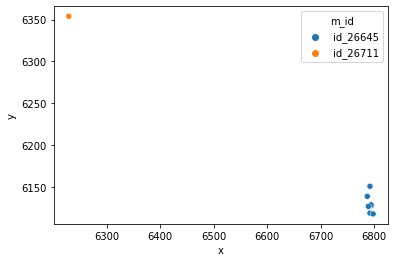

In [539]:
sns.scatterplot(data=mdots[(mdots.group=="MED1-MYC_MEF2D-VHL-G1--11--1-2_2") & (mdots.x> 6000) & abs(mdots.x<6800) & (mdots.y>6000) & (mdots.y<6900)], x="x", y="y", hue="m_id")

## aggregating

In [540]:
mdots = mdots.drop(columns=["parent_id", "id", 'count_red', 'count_green', "filename"])
grouping = {i: "mean" for i in mdots.columns}
grouping.update({
    "image": "first",
    "z": ["mean", "min", "max"],
    'area': ["sum", "min", "max"],
    "class": "unique",
    "group" : "first",
    "exp" : "first",
    "treat" : "first",
    "part" : "first",
    "mean_red" : ["mean", "var"],
    "mean_green" : ["mean", "var"],
    "mean_dapi" :["mean", "var"],
    "pixsum_red" : "sum",
    "pixsum_green" : "sum",
    "pixsum_dapi" : "sum",
    "sum_red" : "sum",
    "sum_green" : "sum",
    "sum_dapi" : "sum",
})
grouping.pop('m_id')

'mean'

In [541]:
# merge into a same sample
groups = mdots.groupby("m_id")
counts = groups['image'].count()
mmdots = groups.agg(grouping)
mmdots['counts'] = counts
mmdots = mmdots[mmdots['counts']>1]
mmdots.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mmdots.columns]
#rename colors
mmdots['class'] = [i[0] if len(i)==1 else "cobinding" for i in mmdots["class_unique"]]
mmdots = mmdots.drop(columns="class_unique")
mdots = mmdots

In [542]:
mred = fish.colocalize(dots[dots['class']=='red'], distance_scale=1.2)

mred = mred.drop(columns=["parent_id", "id", 'count_red', 'count_green', "filename"])
grouping = {i: "mean" for i in mred.columns}
grouping.update({
    "image": "first",
    "z": ["mean", "min", "max"],
    'area': ["sum", "min", "max"],
    "class": "first",
    "group" : "first",
    "exp" : "first",
    "treat" : "first",
    "part" : "first",
    "mean_red" : ["mean", "var"],
    "mean_green" : ["mean", "var"],
    "mean_dapi" :["mean", "var"],
    "pixsum_red" : "sum",
    "pixsum_green" : "sum",
    "pixsum_dapi" : "sum",
    "sum_red" : "sum",
    "sum_green" : "sum",
    "sum_dapi" : "sum",
})
grouping.pop('m_id')

# merge into a same sample
groups = mred.groupby("m_id")
counts = groups['image'].count()
mred = groups.agg(grouping)
mred['counts'] = counts
mred = mred[mred['counts']>1]
mred.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mred.columns]
#rename mred
mred = mred.drop(columns="class_unique")

MEF2D-MYC_MEF2D-VHL-G1--5--5-1
MEF2D-MYC_MEF2D-VHL-G1--5--3-1
MED1-MYC_MEF2D-VHL-G1--11--2-2


/home/jeremie/genepy/genepy/imaging/fish.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdot[mergedidcol]=None
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


MEF2D-MYC_MEF2D-VHL-G1--5--1-1_2
MED1-MYC_MEF2D-DMSO-G1--13--4-3_2
MED1-MYC_MEF2D-VHL-G1--11--3
MEF2D-MYC_MEF2D-DMSO-G1--4--3-1
MED1-MYC_MEF2D-VHL-G1--11--6-3_2
MED1-MYC_MEF2D-DMSO-G1--13--3-3
MEF2D-MYC_MEF2D-DMSO-G1--4--3-2_1
MEF2D-MYC_MEF2D-VHL-G1--5--1-1
MED1-MYC_MEF2D-DMSO-G1--13--4-3
MEF2D-MYC_MEF2D-VHL-G1--5--2-3
MEF2D-MYC_MEF2D-VHL-G1--5--4-1
MED1-MYC_MEF2D-VHL-G1--11--4-2-2_2
MED1-MYC_MEF2D-DMSO-G1--13--2-1
MEF2D-MYC_MEF2D-VHL-G1--5--4-3_1
MED1-MYC_MEF2D-VHL-G1--11--4-2_2
MED1-MYC_MEF2D-DMSO-G1--13--5-1_1
MEF2D-MYC_MEF2D-VHL-G1--5--4-2
MEF2D-MYC_MEF2D-VHL-G1--5--2-4
MEF2D-MYC_MEF2D-DMSO-G1--4--4-1
MED1-MYC_MEF2D-DMSO-G1--13--2-2
MEF2D-MYC_MEF2D-DMSO-G1--1--1-1_2
MED1-MYC_MEF2D-VHL-G1--11--3_1
MEF2D-MYC_MEF2D-DMSO-G1--4--3-1_2
MED1-MYC_MEF2D-VHL-G1--11--2-2_2
MED1-MYC_MEF2D-VHL-G1--11--4-2-2
MEF2D-MYC_MEF2D-DMSO-G1--4--5-1
MEF2D-MYC_MEF2D-DMSO-G1--1--1-2
MEF2D-MYC_MEF2D-DMSO-G1--4--9-1
MED1-MYC_MEF2D-DMSO-G1--13--3-5_2
MED1-MYC_MEF2D-DMSO-G1--13--4-2_2
MED1-MYC_MEF2D-VHL-G1--11-

KeyError: "['class_unique'] not found in axis"

In [ ]:
#todo: tocode
def aggregate(data, todrop, groupby, countcol, default_agg, optional_agg, mincount):
    cells = cells.drop(columns=["max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi", "parent_id", "id", "filename"])

    grouping = {i: "first" for i in cells.columns}
    grouping.update({
        "area": ["sum","min","max"],
        "x": "mean",
        "y": "mean",
        "z": ["max", "min"],
        "count_red": "sum",
        "count_green": "sum",
    })
    groups = cells.groupby('group')
    counts = groups['image'].count()
    mcells = groups.agg(grouping)
    mcells['counts'] = counts
    mcells = mcells[mcells['counts']>1]
    mcells.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mcells.columns]

In [547]:
cells = cells.drop(columns=["max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi", "parent_id", "id"])

grouping = {i: "first" for i in cells.columns}
grouping.update({
    "area": ["sum","min","max"],
    "x": "mean",
    "y": "mean",
    "z": ["max", "min"],
    "count_red": "sum",
    "count_green": "sum",
})
groups = cells.groupby('group')
counts = groups['image'].count()
mcells = groups.agg(grouping)
mcells['counts'] = counts
mcells = mcells[mcells['counts']>1]
mcells.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mcells.columns]

## compute differences (number/surface/max/min/mean) across cells

### text

In [554]:
# compute difference in signal strength between cells &  between conditions across cells
strength = {}
for k in set(mdots.exp):
    print('\n______________________________')
    print(k)
    for val in ['mean_red_mean', 'mean_green_mean','area_sum']:
        print(val)
        a = []
        for e in ['DMSO', 'VHL']:
            print('\n')
            print(e)
            d = mdots[(mdots.exp==k)&(mdots.treat==e)]
            e = pd.DataFrame([
                [d[d['class']=="cobinding"][val].mean(), d[d['class']=="cobinding"][val].var()**(1/2)],
                [d[d['class']=="green"][val].mean(), d[d['class']=="green"][val].var()**(1/2)],
                [d[d['class']=="red"][val].mean(), d[d['class']=="red"][val].var()**(1/2)]
            ], columns=['mean','var'], index=["obs_cob", "obs_green", "obs_red"])
            print(e)
            a.append(e)
        strength[k] = e
        print("\nchange (VHL/DMSO)\n"+str(a[1]['mean']/a[0]['mean']))


______________________________
MEF2D-MYC_MEF2D
mean_red_mean


DMSO
                  mean          var
obs_cob    4660.493879  2422.369420
obs_green   777.476722   626.104495
obs_red    4966.885209  1692.117184


VHL
                  mean          var
obs_cob    1961.582006          NaN
obs_green   209.067414   155.774133
obs_red    3394.720670  1737.125377

change (VHL/DMSO)
obs_cob      0.420896
obs_green    0.268905
obs_red      0.683471
Name: mean, dtype: float64
mean_green_mean


DMSO
                  mean          var
obs_cob    1906.983049  1083.982120
obs_green  2425.551183   867.814683
obs_red     264.301220   213.872788


VHL
                  mean         var
obs_cob     312.162210         NaN
obs_green  1803.546091  697.961291
obs_red      43.301159   71.623501

change (VHL/DMSO)
obs_cob      0.163694
obs_green    0.743561
obs_red      0.163833
Name: mean, dtype: float64
area_sum


DMSO
                   mean           var
obs_cob    2.124848e+06  1.305772e+06
obs_gree

In [523]:
# compute difference in number/surface/max/min/mean(val) of green /red across cells and cobindings
data = {}
typ = [("sum_green_sum", "green"), ('sum_red_sum', "red"), ("area_sum", "size")]
for k in set(mdots.exp):
    a = []
    print(k)
    print('______________________________\n')
    at = pd.DataFrame()
    
    for t in ['DMSO', 'VHL']:
        print(t)
        d = mdots[(mdots.exp==k)&(mdots.treat==t)]
        
        a = pd.DataFrame()
        b = pd.DataFrame()
        print("\ncount greens per cell:")
        e = [len(d[(d["group"]==cell)&(d['class']=="green")]) for cell in set(d.group)]
        print(min(e))
        print(np.mean(e), np.sqrt(np.var(e)))
        
        b["color"] = ['on green']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="red")]) for cell in set(d.group)]
        b["color"] = ['on red']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="cobinding")]) for cell in set(d.group)]
        b["color"] = ['on coloc']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        a['type'] = "counts"
        a['cond'] = t
        at = at.append(a)
        
        for (col,name) in typ:
            print(name)
            a = pd.DataFrame()
            print('\nsignal in green:')
            e = d[d['class']=="green"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on green"
            a = a.append(b)
            
            print('\nsignal in red:')
            e = d[d['class']=="red"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] =  e
            b['color'] = "on red"
            a = a.append(b)

            print('\nsignal in cobinding:')
            e = d[d['class']=="cobinding"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on coloc"           
            print('\n\n')
            a = a.append(b)
            a['type']=name
            a['cond'] = t
            at = at.append(a)
        print('____________\n')
    data[k] = at.reset_index(drop=True)

MEF2D-MYC_MEF2D
______________________________

DMSO

count greens per cell:
153.125 203.75502294422094
green

signal in green:
699785.9804081633 1119997.176347565

signal in red:
508531.2261904762 696341.5150794553

signal in cobinding:
2655027.25 1899235.2691343133



red

signal in green:
159329.8794557823 189088.3905848718

signal in red:
11560141.57142857 12719436.09100039

signal in cobinding:
11455330.5 7559336.670799975



size

signal in green:
229061.0367346939 246408.53504549613

signal in red:
1725996.511904762 1391974.1254675002

signal in cobinding:
2124848.0 1130831.3363926117



____________

VHL

count greens per cell:
5.16 7.12561576286569
green

signal in green:
529085.9612403101 1213496.4267912656

signal in red:
60091.48684210526 73767.78789008922

signal in cobinding:
93959.0 0.0



red

signal in green:
43003.20930232558 68404.8296278381

signal in red:
7130052.447368421 7846655.397740748

signal in cobinding:
887090.0 0.0



size

signal in green:
200515.0465116

In [ ]:
mdots

In [524]:
# adding chi2
for k,val in data.items():
    for i in set(val['type']):
        e = " |"
        for u in set(val['color']):
            a = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "DMSO")]["signal"].tolist()
            b = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "VHL")]["signal"].tolist()
            r = ttest_ind(a, b, equal_var=False)
            e+= u + ": ("f"{r[0]:.1f}, "f"{r[1]:.1e}), "
        val.loc[val[val['type'] == i].index, 'type'] = i + e +"|"
    data[k] = val

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### plots

In [454]:
data[k]

KeyError: 'id_752'

In [525]:
a = data['MEF2D-MYC_MEF2D']

In [526]:
a = a[a.type==a.type[0]]

In [505]:
ttest_ind(a[a.cond=="DMSO"]["signal"].tolist(), a[a.cond=="VHL"]["signal"].tolist(), equal_var=False)

Ttest_indResult(statistic=3.0090906547182805, pvalue=0.003537621308505588)

In [527]:
a[a.cond=="VHL"].mean()

signal    2.746667
dtype: float64

In [528]:
a[a.cond=="DMSO"]

,color,signal,type,cond
0,on green,181.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
1,on green,84.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
2,on green,38.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
3,on green,52.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
4,on green,191.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
...,...,...,...,...
67,on coloc,0.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
68,on coloc,0.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
69,on coloc,0.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO
70,on coloc,0.0,"counts |on green: (3.5, 2.0e-03), on coloc: (1...",DMSO


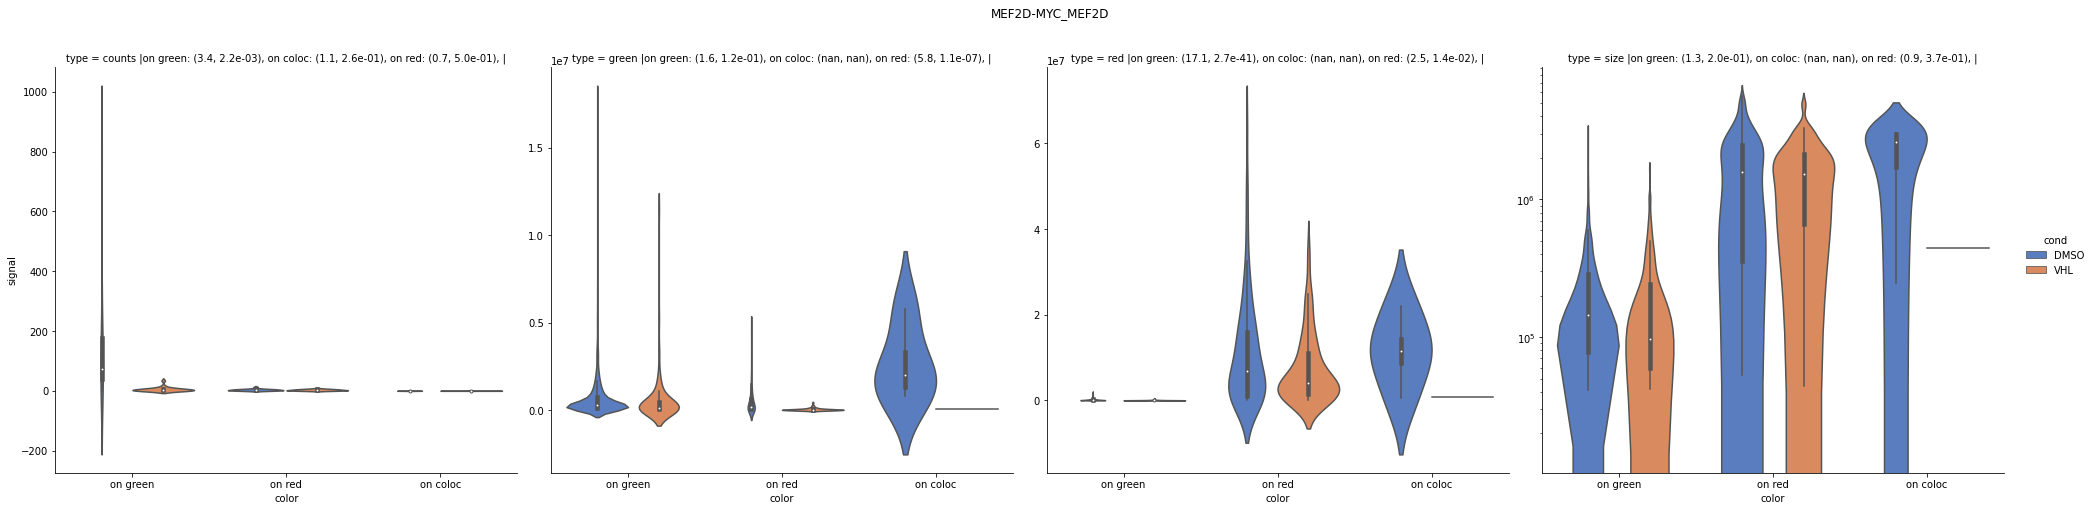

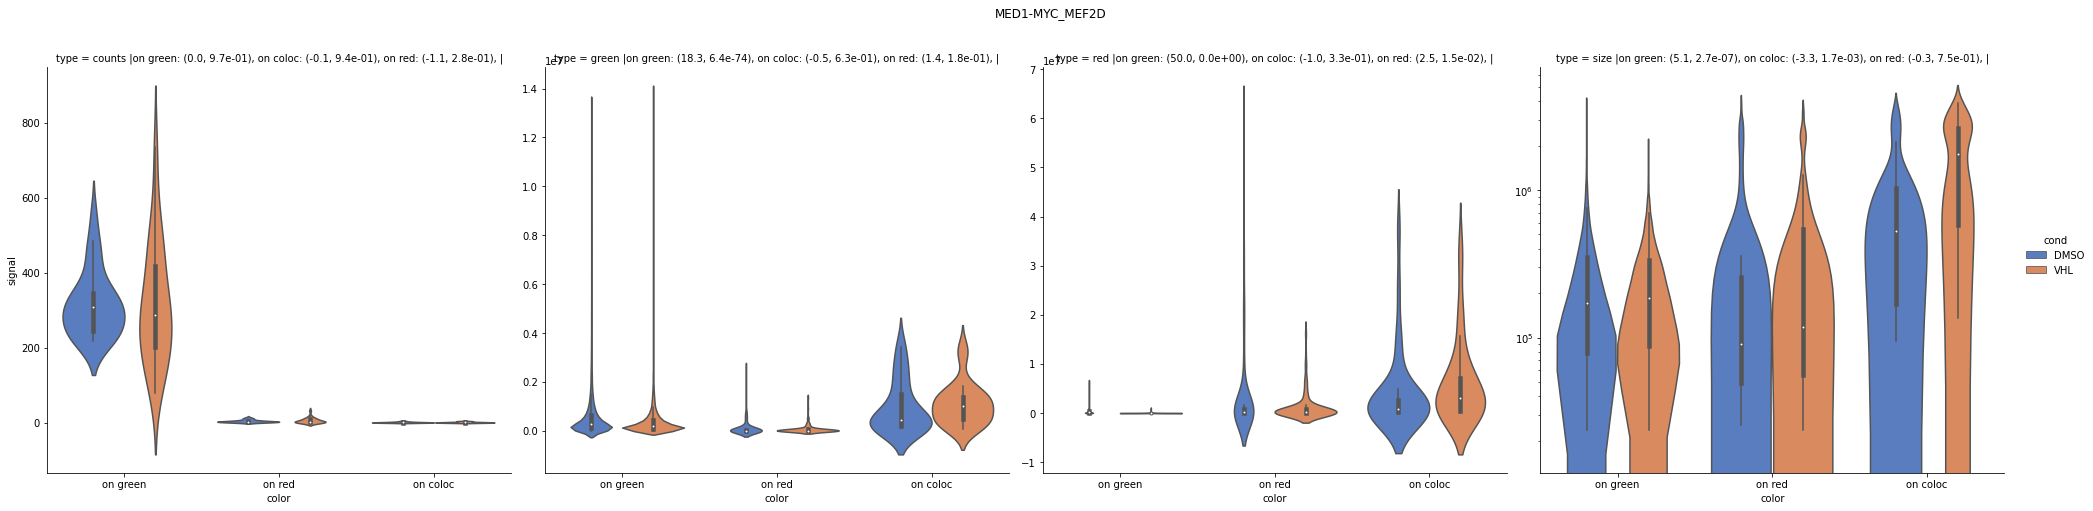

In [397]:
for k, val in data.items():
    g = sns.catplot(kind="violin", x="color", y="signal", hue="cond", col="type", data=val, palette="muted", sharey=False, height=7)
    g.fig.subplots_adjust(top=0.86)
    g.fig.suptitle(k)
    plt.yscale('log')
    plt.show()

## likelyhood of coloc compared to expectation for each experiment &  between conditions

### text

In [482]:
# compute dot likelyhood of coloc compared to expectation for each experiment &  between conditions
enrichment = {}

for k in set(mdots.exp):
    count = []
    fisher = []
    print('______________________________')
    print(k)
    for e in ['DMSO', 'VHL']:
        d = mdots[(mdots.exp==k)&(mdots.treat==e)]
        try:
            obs_cob = len(d[d['class']=="cobinding"])/(len(d[d['class']=="red"])+len(d[d['class']=="cobinding"]))
        except ZeroDivisionError:
            print('no red dot')
            continue
        obs_green = d[d['class']=="green"].area_sum.sum()
        pred_cob = obs_green / mcells[(mcells.exp==k)&(mcells.treat==e)].area_sum.sum()
        #print(obs_cob, obs_green, pred_cob)
        count.append(obs_cob/pred_cob)
        print(e+": "+str(obs_cob/pred_cob))
        a = pred_cob*len(d[d['class']!="green"])
        b = obs_cob*len(d[d['class']!="green"])
        f = fisher_exact(np.array([[b, len(d[d['class']!="green"]) - b], [a, len(d[d['class']!="green"])- a]], dtype=int))
        if f[0] is np.inf:
            f = (obs_cob/pred_cob, f[1])
        fisher.append(f)
    enrichment[k] = fisher
    print("change: "+str(count[1]/count[0]))

______________________________
MEF2D-MYC_MEF2D
DMSO: 11.155006619243961
VHL: 69.59702876046195
change: 6.239084487892392
______________________________
MED1-MYC_MEF2D
DMSO: 11.148494708949418
VHL: 11.967238129710655
change: 1.0734398178530768


In [216]:
enrichment

{'MEF2D-MYC_MEF2D': [(11.104428275651795, 0.1211241624393013), (nan, 1.0)],
 'MED1-MYC_MEF2D': [(19.20940170940171, 2.777973890917427e-08),
  (18.846625766871167, 2.0359317498429956e-08)]}

### plot

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

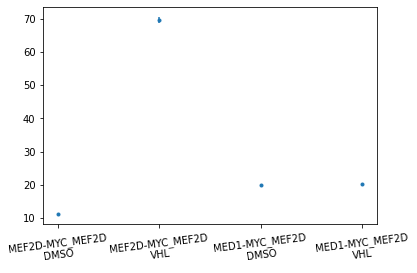

In [483]:
x=[]
y=[]
e=[]
for k, val in enrichment.items():
    x.append(k+'\nDMSO')
    y.append(val[0][0])
    e.append(val[0][1])
    x.append(k+'\nVHL')
    y.append(val[1][0])
    e.append(val[1][1])
plt.errorbar(x, y, e, linestyle='None', marker='.')
plt.xticks(rotation = 7) # Rotates X-Axis Ticks by 45-degrees

## plot of averaged binned signal by distance from focis

In [476]:
# make a plot of averaged binned signal strength by distance from locis
dists= {}
newdists = {}
for val in set(mdots.exp):
    for e in ['DMSO', 'VHL']:
        d = dots[(dots.exp==val)&(dots.treat==e)]
        dist = np.array([])
        weight = np.array([])
        newdist = pd.DataFrame()
        m = mred[(mred.exp==val)&(mred.treat==e)]
        print(val, e)
        for k, v in m.iterrows():
            #dist = np.append(dist, distance_matrix(d[d['class']=="green"][['x', "y", "z"]].values, np.array([v[['x_mean', "y_mean", "z_mean"]]])).T[0].astype(float))
            #weight = np.append(weight, d[d['class'] != "red"]["sum_green"])
            
            a = d[d['class']=="green"][['x',"y","z"]] - v[['x_mean', "y_mean", "z_mean"]].values
            a["sum_green"] =  d[d['class']=="green"]["sum_green"]
            newdist = newdist.append(a)
        newdists[val+e] = newdist
        #dists[val+e] = [dist, weight]

MEF2D-MYC_MEF2D DMSO
MEF2D-MYC_MEF2D VHL
MED1-MYC_MEF2D DMSO
MED1-MYC_MEF2D VHL


In [487]:
dots[(dots.exp=="MEF2D-MYC_MEF2D")&(dots.treat=="VHL")]

,image,parent_id,id,area,x,y,z,class,count_red,count_green,...,sum_green,sum_dapi,sum2_red,sum2_green,sum2_dapi,filename,group,exp,treat,part
142803,5,4,5,20577,6768,6942,255,green,0,0,...,25828.0,94313.0,5.770340e+05,3.278296e+07,4.921380e+08,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--1-1_1,MEF2D-MYC_MEF2D,VHL,1-1_1
142806,5,4,5,71530,6723,6925,425,green,0,0,...,138807.0,182073.0,6.116180e+06,3.238597e+08,7.876232e+08,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--1-1_1,MEF2D-MYC_MEF2D,VHL,1-1_1
142808,5,4,5,74470,6703,6909,510,green,0,0,...,196238.0,187121.0,6.185692e+06,6.359862e+08,8.496735e+08,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--1-1_1,MEF2D-MYC_MEF2D,VHL,1-1_1
142810,5,4,5,85249,6697,6914,595,green,0,0,...,261602.0,197686.0,6.665970e+06,1.078096e+09,8.766448e+08,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--1-1_1,MEF2D-MYC_MEF2D,VHL,1-1_1
142811,5,4,6,57812,10995,8182,595,green,0,0,...,138691.0,92057.0,2.543220e+05,3.898541e+08,4.247283e+08,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--1-1_1,MEF2D-MYC_MEF2D,VHL,1-1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146541,5,3,5,97007,8871,5246,4165,red,0,0,...,10658.0,758323.0,1.575857e+09,2.140166e+06,6.326532e+09,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--5-1,MEF2D-MYC_MEF2D,VHL,5-1
146543,5,3,4,151880,3366,5018,4250,red,0,0,...,12734.0,864877.0,2.226853e+09,2.323508e+06,5.750569e+09,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--5-1,MEF2D-MYC_MEF2D,VHL,5-1
146545,5,3,4,126403,3368,5040,4335,red,0,0,...,11763.0,737902.0,1.433492e+09,2.620575e+06,4.903407e+09,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--5-1,MEF2D-MYC_MEF2D,VHL,5-1
146547,5,3,4,97987,3376,5087,4420,red,0,0,...,5565.0,459092.0,7.547584e+08,9.062890e+05,2.542371e+09,MEF2D-MYC_MEF2D-VHL-G1,MEF2D-MYC_MEF2D-VHL-G1--5--5-1,MEF2D-MYC_MEF2D,VHL,5-1


In [464]:
dist

array([5651.00185232, 5622.80451618, 2622.64703561, ..., 7447.61665946,
       7527.98051646, 7603.38037693])

In [475]:
v[0][v[0]<180]

array([140.143861  , 111.81231633,  55.83969024, 170.15660554,
       120.90663036, 117.97511412, 170.31143442, 140.47414244,
       143.16967599, 178.34793157, 144.69285477, 118.9689969 ,
       168.99571973, 147.75021055, 138.86192983, 152.29697597,
       154.09380981, 169.09166093,  97.72478014, 144.56060382,
       128.48330313, 106.10016446, 132.44282555, 179.45700412,
       165.62639295, 127.61369012, 146.94473079, 132.53469148,
       110.01868528, 152.76925229, 150.59886222, 155.44266539,
       141.09940645, 138.06680448, 147.67207759, 145.307751  ,
       144.04378192,  82.65960991,  86.93643911, 147.84207039,
       160.13395781, 134.62498513,  76.1329098 , 113.79882396,
        65.48450164, 109.57441895, 163.54386274, 146.08891984,
       166.99494753, 129.53884553, 127.05436828,  33.01724411,
        86.82550213, 170.4366974 , 170.09934445, 177.0239748 ,
       168.55641617, 144.86272813, 177.33473997, 178.01303499,
       137.98203945])

In [469]:
v = dists['MEF2D-MYC_MEF2DDMSO']

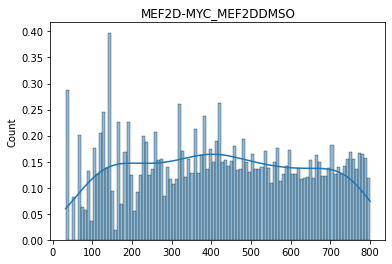

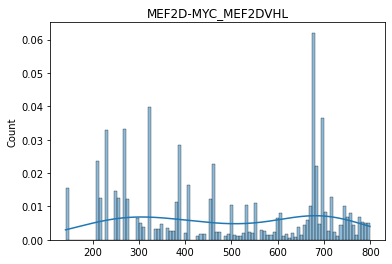

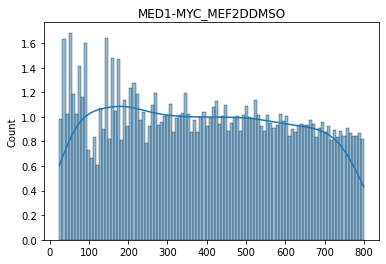

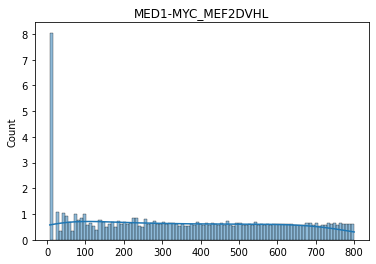

In [456]:
size=600
defa = 40
for k, v in dists.items():
    plt.title(k)
    sns.histplot(x=v[0][v[0]<size], weights=v[1][v[0]<size]/((4*3.14*(defa+v[0][v[0]<size]))**2), kde=True, bins=100, fill=True)
    plt.show()

In [480]:
v

,x,y,z,sum_green
82435,1203.923077,5303.153846,-1536.538462,17240.0
82437,1216.923077,5294.153846,-1451.538462,23502.0
82439,540.923077,2172.153846,-1366.538462,9186.0
82440,1193.923077,5307.153846,-1366.538462,15249.0
82442,517.923077,2191.153846,-1281.538462,10382.0
...,...,...,...,...
142790,2989.875,1426.625,6502.5,17929.0
142792,2984.875,1415.625,6587.5,20308.0
142794,2984.875,1426.625,6672.5,18061.0
142796,3008.875,1397.625,6757.5,12699.0


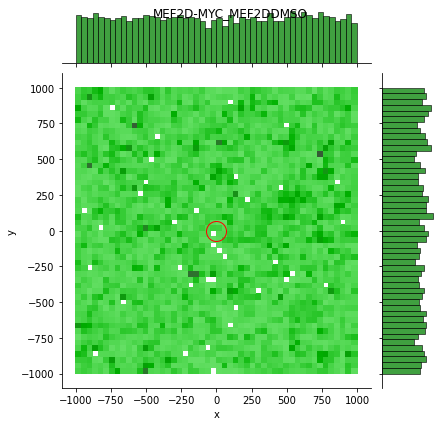

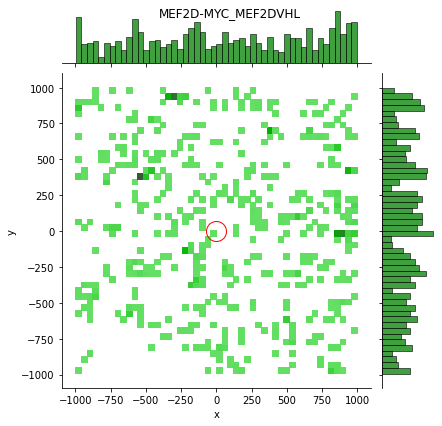

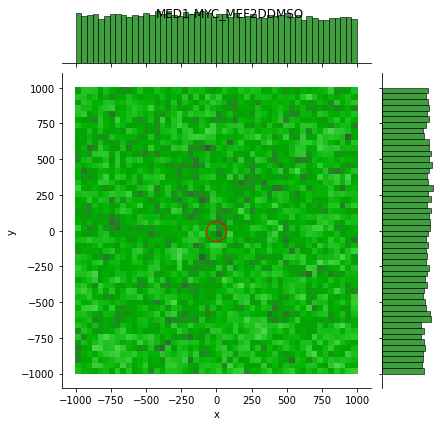

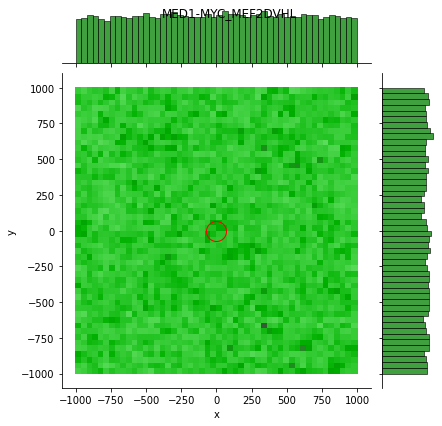

In [481]:
size=1000
bins=50
s = 20
for k, v in newdists.items():
    p = sns.jointplot(data=v[(abs(v.x)<size) & (abs(v.y)<size) & (abs(v.z)<size)], x="x", y="y",  kind="hist", weights=v[(abs(v.x)<size) & (abs(v.y)<size)& (abs(v.z)<size)].sum_green, bins=bins, marginal_kws=dict(bins=bins), palette="viridis", color="green", kde=True)
    # gridsize=50, kind="hex", marginal_kws=dict(bins=50))
    # hue="sum_green_sum")
    x_values = [0]#, 2, 3, 4]
    y_values = [0]#, 0, 0, 0]
    p.ax_joint.plot(x_values, y_values, 'o', ms=s, markerfacecolor="None",
         markeredgecolor='red', markeredgewidth=1)
    p.fig.suptitle(k)
    plt.show()

In [ ]:
# apply plot to old data from juliana    

In [ ]:
# make a nice fake plot
sns.plot()